# 'What is the next step for my business? '#
* The proposed project for the data incubator
* Yun Zhang

## 1. **Introduction**
### 1.1 **Project Motivation**
Market feedback is not only the main factor to indicate how successful business is, it also provides valuable resources for business owners to learn how to improve products and service to achieve their business goals. One common problem that business owners have to face to is "What is the next step for my business?". They may want to know any specific strategy related to business operation like 'whether my business should extend weekday business hours', 'whether more types of food needs to be provided', and more importantly 'what needs to be done first'. The analysis of large data on market trends, consumer rating/review and competitor information may be the key to answer these questions. However, owners of local business, especially small self-employed business, may hardly collect and analyze enough data due to technical and financial difficulties. Yelp may be a good alternative that provides direct consumer feedback including rating and reviews. However, the average rating from Yelp may be not effective enough to indicate a specific move to improve business, while the text-based user review is time-consuming to read, analyze and extract useful information. And it becomes even more difficult when analyzing competitors or general market trends. Therefore, I propose to develop a recommender for strategies of business operations, which analyzes the impacts from business category, service, operational hour, location, user review and other related factors, and provides different strategies and their priority order to attract more customers (more number of review count) and improve customer rating. More details will be discussed in Section 2.

### 1.2 **Data decription**
The dataset that will be analyzed in this project is provided by Yelp for its 9th dataset challenge, and the data is accessible online and can be downloaded from the website https://www.yelp.com/dataset_challenge. The dataset includes five portions for user, user reviews, check-in, business and user tips. The size of the dateset is approximately 5GB with information of about 0.14 million business, 1.02 million users and 4.15 million reviews. The business portion provides data on business location, operation hours, attribute, category, review count and average rating, all of which are the main drivers of the proposed predicted model for customer rating and count.

## 2. **Project objective and methodology**
There are five goals of the proposed project at different stages of development. 
1. Develop a predictive model for customer rating and review count based on business location, types and categories of attributes, service provided, operational hour and other related factors. The continous rating will be divided into 5 categories, which turns the predictive model as a classification problem. At this stage, data cleansing will be finished with multiple explorary data analysis, and the predicted model will be developed by applying different classification models including logistic regression, support vector machines (SVM), random forest and etc.. Model and feature selection will be conducted based on the cross-validation method.

2. Build a tool that efficiently extracts and compares useful information from related reviews and reviewers on any existing business and its top-rated competitors. The useful information may include word frequency for different rating values ('which word is the most important for good and bad ratings'), rating distribution ('whether the rating is consistently distributed or polarized') and the relationship between rating and user social network ('whether any user's rating will affect his friends'). In addition, the comparison of user reviews with top-rated competitors will help business owners understand their shortcomings in customer experience and services. This may further benefit business strategy decision.

3. Complete a recommender that predicts the significance of different business factors to improve business review rating and count, provides the priority order to indicate which factor should be improved first (like 'whether more types of food, parking lot or free wifi are the most important to improve rating'), suggest difference in the top-rated competitors and analyze customer reviews to extract what customers care most for more insight on business strategy. 

4. Complete a recommender for new business. Given business category and location, the recommender provides information for business operation and strategy of top-rated potential competitors.

5. Create an interactive web application to implement the proposed recommender and visualize results with Heroku. 

## 3. **Data preprocessing**

#### 3.1 import packages

In [1]:
%matplotlib notebook
import pandas as pd
from itertools import groupby
import re
import math
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

#### 3.2 Transfer the original json file into csv
* use function convert_from_json_to_csv.py
* the list for each column is treated as string with separator '\_\'
* load into the csv data

In [2]:
# check data
#tip=pd.read_csv('yelp_csv/yelp_academic_dataset_tip.csv')
checkin=pd.read_csv('yelp_csv/yelp_academic_dataset_checkin.csv')
#user=pd.read_csv('yelp_csv/yelp_academic_dataset_user.csv')
#review=pd.read_csv('yelp_csv/yelp_academic_dataset_review.csv')
business=pd.read_csv('yelp_csv/yelp_academic_dataset_business.csv')

In [5]:
checkin['time'].head(5)

0    Fri-0:2/_/Sat-0:1/_/Sun-0:1/_/Wed-0:2/_/Sat-1:...
1    Mon-13:1/_/Thu-13:1/_/Sat-16:1/_/Wed-17:1/_/Su...
2              Thu-0:1/_/Mon-1:1/_/Mon-12:1/_/Sat-16:1
3    Fri-0:1/_/Sat-0:1/_/Sun-0:1/_/Thu-0:1/_/Wed-0:...
4                       Sat-11:1/_/Fri-13:1/_/Thu-14:1
Name: time, dtype: object

In [4]:
checkin['time'][125506]

'Fri-1:1/_/Tue-1:1/_/Mon-2:1/_/Sat-2:1/_/Thu-2:1/_/Thu-22:1'

In [14]:
business[business['business_id']==checkin['business_id'][14]]

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,type
91984,32085 Electric Blvd,Alcohol: full_bar/_/Ambience: {'romantic': Fal...,FQM4pVt1jeZcBGLIsXhXNA,Wine Bars/_/American (New)/_/Bars/_/Restaurant...,Avon Lake,Monday 11:30-22:0/_/Tuesday 11:30-22:0/_/Wedne...,1,41.508717,-81.988746,Fratello's,NaN,44012,33,4.5,OH,business


#### 3.3 Data preprocessing
* modify features for each data
* filter out useless data
* change option into dummy vection
#### 3.3.1 business data 

In [3]:
# drop useless columns
business.drop(['address','is_open','name','neighborhood',
               'type','postal_code','longitude','latitude','city'],axis=1,inplace=True)
business.head(3)

,attributes,business_id,categories,hours,review_count,stars,state
0,BikeParking: True/_/BusinessAcceptsBitcoin: Fa...,0DI8Dt2PJp07XkVvIElIcQ,Tobacco Shops/_/Nightlife/_/Vape Shops/_/Shopping,Monday 11:0-21:0/_/Tuesday 11:0-21:0/_/Wednesd...,17,4.5,AZ
1,BusinessAcceptsBitcoin: False/_/BusinessAccept...,LTlCaCGZE14GuaUXUGbamg,Caterers/_/Grocery/_/Food/_/Event Planning & S...,Monday 0:0-0:0/_/Tuesday 0:0-0:0/_/Wednesday 0...,9,5.0,NV
2,"Alcohol: none/_/Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,Restaurants/_/Pizza/_/Chicken Wings/_/Italian,Monday 11:0-2:0/_/Tuesday 11:0-2:0/_/Wednesday...,7,2.5,ON


In [4]:
# data general description for numerical column 
business.describe()

,review_count,stars
count,144072.000000,144072.000000
mean,28.825511,3.637709
std,92.574711,0.969585
min,3.000000,1.000000
25%,4.000000,3.000000
50%,9.000000,3.500000
75%,22.000000,4.500000
max,6414.000000,5.000000


In [12]:
# business category
# define the main category for each business
# generate the dummy vector for category
# business_category_dummy=list()
# for x in business['categories']:
#    business_category_dummy.append(str(x).replace('&','/_/'))
# business_category_dummy=pd.Series(business_category_dummy).str.get_dummies('/_/')
# business_category_dummy.to_csv('dummy_vector_for_category.csv')
business_category_dummy=pd.read_csv('yelp_csv/dummy_vector_for_category.csv',index_col='Unnamed: 0')

In [13]:
# get the business number for each city
category_freq=business_category_dummy.sum()
business_category_dummy=None # to save memory
category_freq.sort_values(ascending=False,inplace=True)
category_freq=category_freq.reset_index()
category_freq.columns=['Category','Freq']
category_freq.head(10)

,Category,Freq
0,Restaurants,48485
1,Shopping,22466
2,Food,21189
3,Beauty & Spas,13711
4,Home Services,11241
5,Nightlife,10524
6,Health & Medical,10476
7,Bars,9087
8,Automotive,8554
9,Local Services,8133


In [15]:
category_freq[category_freq['Freq']<500]['Freq'].sum()

83198

In [7]:
# number of categories for business
print('There are',len(category_freq),'categories of business.')
category_freq.describe()

There are 1192 categories of business.


,Freq
count,1192.000000
mean,442.893456
std,1965.394211
min,1.000000
25%,10.000000
50%,50.000000
75%,245.250000
max,48485.000000


In [16]:
# categories frequency < 0.5% will consider as special type
category_rare=category_freq[category_freq['Freq']<500]['Category'].values.tolist()

In [61]:
# combine all rare category witn 'nan' into 'rare category'
business_category_dummy['rare']=business_category_dummy[category_rare].sum(axis=1)
business_category_dummy['rare']=business_category_dummy['rare']+business_category_dummy['nan']

In [62]:
# drop rare category and 'nan'
category_rare.append('nan')
business_category_dummy.drop(category_rare,axis=1,inplace=True)

In [74]:
# change 'rare' value to 1 for any positive value
business_category_dummy['rare']=business_category_dummy['rare'].apply(lambda x: 1 if x>0 else 0)

In [9]:
# save business_category_dummy to csv 
# read it to save time 
#business_category_dummy.to_csv('yelp_csv/dummy_vector_for_category_simplified.csv')
business_category_dummy=pd.read_csv('yelp_csv/dummy_vector_for_category_simplified.csv',index_col='Unnamed: 0')

In [10]:
# check results
business_category_dummy.describe()

,Accessories,Active Life,American (New),American (Traditional),Apartments,Appliances,Appliances & Repair,Art Galleries,Arts & Crafts,Arts & Entertainment,...,Veterinarians,Vietnamese,Vintage & Consignment,Waxing,Wedding Planning,Wine & Spirits,Wine Bars,Women's Clothing,Yoga,rare
count,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,...,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000,144072.000000
mean,0.009745,0.046657,0.025133,0.036870,0.011036,0.003804,0.003838,0.003811,0.008642,0.032768,...,0.006663,0.005935,0.003887,0.007663,0.003547,0.010974,0.006053,0.015055,0.005941,0.386744
std,0.098236,0.210904,0.156530,0.188444,0.104472,0.061557,0.061836,0.061613,0.092558,0.178030,...,0.081357,0.076807,0.062224,0.087202,0.059450,0.104179,0.077562,0.121772,0.076852,0.487006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# merge business_category_dummy into business
# combine the dummy column with the original business
business=pd.concat([business, business_category_dummy], axis=1)

In [12]:
# drop category column for business
business.drop('categories',axis=1,inplace=True)

In [38]:
# business location city
# The yelp data is for 11 cities which is seperated by state
# after check the data we have the following pair
# 'Edinburgh'=['EDH','ELN','ESX','FAL','FIF','FLN','HLD','KHL','MLN','NLK','NTH','PKN','SCB','STG','WLN']
# 'Karlsruhe'=['BW','NI']
# 'Tronto'='ON'
# 'Montreal'='QC'
# 'Pittsburgh'='PA'
# 'Charlotte'='NC'
# 'Urbana-Champaign'='IL'
# 'Phoenix'='AZ'
# 'Las Vegas'='NV'
# 'Maddison'='WI'
# 'Cleveland'='OH'
# delete rate state 'NY','SC','VT'
Edinburgh_state_list=['EDH','ELN','ESX','FAL','FIF','FLN','HLD',
 'KHL','MLN','NLK','NTH','PKN','SCB','STG','WLN']
business['state']=business['state'].apply(lambda x: 'Edinburgh' if x in Edinburgh_state_list else x)
business['state']=business['state'].apply(lambda x: 'Karlsruhe' if x in ['BW','NI'] else x)
business['state']=business['state'].apply(lambda x: 'Tronto' if x=='ON' else x)
business['state']=business['state'].apply(lambda x: 'Montreal' if x=='QC' else x)
business['state']=business['state'].apply(lambda x: 'Pittsburgh' if x=='PA' else x)
business['state']=business['state'].apply(lambda x: 'Charlotte' if x=='NC' else x)
business['state']=business['state'].apply(lambda x: 'Urbana-Champaign' if x=='IL' else x)
business['state']=business['state'].apply(lambda x: 'Phoenix' if x=='AZ' else x)
business['state']=business['state'].apply(lambda x: 'Las Vegas' if x=='NV' else x)
business['state']=business['state'].apply(lambda x: 'Maddison' if x=='WI' else x)
business['state']=business['state'].apply(lambda x: 'Cleveland' if x=='OH' else x)
#business=business[(business['state']!='NY') & (business['state']!='SC') & 
#                  (business['state']!='VT')]
business['city']=business['state']
business.drop('state',axis=1,inplace=True)

In [40]:
# make dummy vector for city
business_city_dummy=business['city'].str.get_dummies()
business_city_dummy.to_csv('yelp_csv/dummy_vector_for_city.csv')

In [41]:
# read through csv file to
business_city_dummy=pd.read_csv('yelp_csv/dummy_vector_for_city.csv',index_col='Unnamed: 0')
business=pd.concat([business, business_city_dummy], axis=1)

In [47]:
business.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,Las Vegas,Maddison,Montreal,NY,Phoenix,Pittsburgh,SC,Tronto,Urbana-Champaign,VT
0,"227 E Baseline Rd, Ste J2",BikeParking: True/_/BusinessAcceptsBitcoin: Fa...,0DI8Dt2PJp07XkVvIElIcQ,Tobacco Shops/_/Nightlife/_/Vape Shops/_/Shopping,Phoenix,Monday 11:0-21:0/_/Tuesday 11:0-21:0/_/Wednesd...,0,33.378214,-111.936102,Innovative Vapors,...,0,0,0,0,1,0,0,0,0,0
1,495 S Grand Central Pkwy,BusinessAcceptsBitcoin: False/_/BusinessAccept...,LTlCaCGZE14GuaUXUGbamg,Caterers/_/Grocery/_/Food/_/Event Planning & S...,Las Vegas,Monday 0:0-0:0/_/Tuesday 0:0-0:0/_/Wednesday 0...,1,36.192284,-115.159272,Cut and Taste,...,1,0,0,0,0,0,0,0,0,0
2,979 Bloor Street W,"Alcohol: none/_/Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,Restaurants/_/Pizza/_/Chicken Wings/_/Italian,Tronto,Monday 11:0-2:0/_/Tuesday 11:0-2:0/_/Wednesday...,1,43.661054,-79.429089,Pizza Pizza,...,0,0,0,0,0,0,0,1,0,0


In [48]:
# get the business number for each city
city_freq=business_city_dummy.sum()
city_freq.sort_values(ascending=False,inplace=True)
city_freq=city_freq.reset_index()
city_freq.columns=['City','Freq']

In [49]:
# processing business hours data
# generate 14 columns with day_start_time, day_op_hrs
# -1 means no data
# seperate string into columns 
a=business['hours'].astype(str)
a=a.str.replace(':','/_/')
a=a.str.replace(' ','/_/')
a=a.str.replace('-','/_/')
c=a.apply(lambda x: pd.Series(x.split('/_/')))
c=c.astype(str)

In [50]:
# generate business_operation_hour frame
operation_hour_column_name=['Monday_start_time','Monday_op_hrs',
                           'Tuesday_start_time','Tuesday_op_hrs',
                           'Wednesday_start_time','Wednesday_op_hrs',
                           'Thursday_start_time','Thursday_op_hrs',
                           'Friday_start_time','Friday_op_hrs',
                           'Saturday_start_time','Saturday_op_hrs',
                           'Sunday_start_time','Sunday_op_hrs']
business_operation_hour=pd.DataFrame(-1*np.ones((len(business), 14)),columns=operation_hour_column_name)

In [51]:
# set values for business_operation_hour
column_num=[int(x) for x in list(np.linspace(0,140,29))]
day_list=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for x in column_num:
    for y in day_list:
        business_operation_hour.loc[(c[x]==y) & (business_operation_hour[y+'_start_time']==-1),y+'_start_time']=c[(c[x]==y) & (business_operation_hour[y+'_start_time']==-1)][x+1]
        business_operation_hour.loc[c[x]==y,y+'_op_hrs']=c[c[x]==y][x+3]

In [52]:
# processing the data, calculate op_hrs
business_operation_hour=business_operation_hour.astype(int)
for y in day_list:
    column_name=y+'_op_hrs'
    column_name1=y+'_start_time'
    business_operation_hour[column_name]=business_operation_hour[column_name].apply(lambda x: 24 if x==0 else x)
    business_operation_hour[column_name]-=business_operation_hour[column_name1]
    business_operation_hour.loc[(business_operation_hour[column_name]<0) & 
                              (business_operation_hour[column_name1]!=-1),column_name]+=24    
    business_operation_hour.loc[business_operation_hour[column_name]==0,column_name]=-1

In [53]:
# check operation hour data
business_operation_hour.head(5)

,Monday_start_time,Monday_op_hrs,Tuesday_start_time,Tuesday_op_hrs,Wednesday_start_time,Wednesday_op_hrs,Thursday_start_time,Thursday_op_hrs,Friday_start_time,Friday_op_hrs,Saturday_start_time,Saturday_op_hrs,Sunday_start_time,Sunday_op_hrs
0,11,10,11,10,11,10,11,10,11,11,10,12,11,7
1,0,24,0,24,0,24,0,24,0,24,0,24,0,24
2,11,15,11,15,11,15,11,16,11,16,11,16,11,15
3,-1,-1,10,11,10,11,10,11,10,8,9,7,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [54]:
# save
business_operation_hour.to_csv('yelp_csv/dummy_vector_for_operation_hour.csv')

In [ ]:
# merge with business
business=pd.concat([business, business_operation_hour], axis=1)
business.drop('hours',axis=1)

In [3]:
# process business attributes
a=business['attributes'].astype(str)
a=a.str.replace("': ",'_')
a=a.str.replace("'",'')
a=a.str.replace("}",'')
a=a.str.replace(": {",'/_/')
a=a.str.replace(": ",'/_/')
a=a.str.replace(", ",'_')

In [4]:
c=a.apply(lambda x: pd.Series(x.split('/_/')))

In [5]:
b=set()
c=c.astype(str)
for x in [int(x) for x in list(np.linspace(0,66,34))]:
    b=b.union(set(c[x].values.tolist()))
b=[x for x in b if x!='nan']

In [6]:
business_attribute=pd.DataFrame(-1*np.ones((len(business), len(b))),columns=list(b))

In [7]:
for x in [int(x) for x in list(np.linspace(0,66,34))]:
    for y in list(b):
        business_attribute.loc[c[x]==y,y]=c.loc[c[x]==y,x+1]

In [8]:
business_attribute.columns

Index(['GoodForKids', 'RestaurantsTakeOut', 'Caters', 'RestaurantsDelivery',
       'GoodForMeal', 'RestaurantsPriceRange2', 'RestaurantsReservations',
       'HappyHour', 'BusinessParking', 'RestaurantsCounterService',
       'DriveThru', 'HairSpecializesIn', 'BusinessAcceptsCreditCards',
       'WheelchairAccessible', 'RestaurantsAttire', 'RestaurantsGoodForGroups',
       'ByAppointmentOnly', 'RestaurantsTableService',
       'BusinessAcceptsBitcoin', 'Smoking', 'Ambience', 'BikeParking', 'HasTV',
       'AcceptsInsurance', 'DogsAllowed', 'Corkage', 'DietaryRestrictions',
       'CoatCheck', 'Open24Hours', 'BYOB', 'GoodForDancing', 'BestNights',
       'OutdoorSeating', 'Music', 'AgesAllowed', 'BYOBCorkage', 'NoiseLevel',
       'WiFi', 'Alcohol'],
      dtype='object')

In [ ]:
# check the unique values for each feature
set(business_attribute['DietaryRestrictions'].values.tolist())

In [9]:
# get the dictionary for attribute
# ['BYOB', 'CoatCheck','Caters','HasTV','WheelchairAccessible','AcceptsInsurance',
# 'DogsAllowed','RestaurantsTableService','BikeParking','RestaurantsDelivery',
# 'Open24Hours','Corkage','HappyHour','ByAppointmentOnly','RestaurantsTakeOut',
# 'OutdoorSeating','DriveThru','RestaurantsCounterService','RestaurantsGoodForGroups',
# 'RestaurantsReservations','BusinessAcceptsBitcoin','GoodForDancing','GoodForKids',
# 'BusinessAcceptsCreditCards']=T/F, -1
# 'BYOBCorkage'='yes_corkage','no','yes_free',-1.0
# 'Smoking'='no','outdoor','yes',-1
# 'AgesAllowed'='18plus','allages','21plus','19plus',-1
# 'NoiseLevel'='very_loud','quiet','loud','average',-1
# 'RestaurantsAttire'='formal','dressy','casual',-1
# 'Alcohol'='full_bar','beer_and_wine','none',-1
# 'WiFi'='free','no','paid',-1
# 'RestaurantsPriceRange2'=4,3,2,1,-1
# ['Ambience','GoodForMeal','BusinessParking','DietaryRestrictions','BestNights','HairSpecializesIn','Music']=dict()
# 'DietaryRestrictions','Music' ,'HairSpecializaesIn','BestNights' are dropped since too small observation has values
# 
TF_list=['BYOB', 'CoatCheck','Caters','HasTV','WheelchairAccessible','AcceptsInsurance',
'DogsAllowed','RestaurantsTableService','BikeParking','RestaurantsDelivery',
'Open24Hours','Corkage','HappyHour','ByAppointmentOnly','RestaurantsTakeOut',
'OutdoorSeating','DriveThru','RestaurantsCounterService','RestaurantsGoodForGroups',
'RestaurantsReservations','BusinessAcceptsBitcoin','GoodForDancing','GoodForKids',
'BusinessAcceptsCreditCards'];
aa=business_attribute.astype(str)
for x in TF_list:
    aa.loc[:,x]=aa[x].map({'True':1,'False':0,'-1.0':-1})
aa.loc[:,'BYOBCorkage']=aa['BYOBCorkage'].map({'yes_corkage':2,'yes_free':1,'no':0,'-1.0':-1})
aa.loc[:,'Smoking']=aa['Smoking'].map({'outdoor':2,'yes':1,'no':0,'-1.0':-1})
aa.loc[:,'AgesAllowed']=aa['AgesAllowed'].map({'18plus':2,'19plus':3,'21plus':4,'allages':1,'-1.0':-1})
aa.loc[:,'NoiseLevel']=aa['NoiseLevel'].map({'very_loud':3,'loud':2,'average':1,'quiet':0,'-1.0':-1})
aa.loc[:,'RestaurantsAttire']=aa['RestaurantsAttire'].map({'formal':2,'dressy':1,'casual':0,'-1.0':-1})
aa.loc[:,'Alcohol']=aa['Alcohol'].map({'full_bar':2,'beer_and_wine':1,'none':0,'-1.0':-1})
aa.loc[:,'WiFi']=aa['WiFi'].map({'free':1,'paid':2,'no':0,'-1.0':-1})
aa.loc[:,'RestaurantsPriceRange2']=aa['RestaurantsPriceRange2'].map({'4':4,'3':3,'2':2,'1':1,'-1.0':-1})

In [10]:
# for Ambience
a=business_attribute['Ambience'].astype(str)
c=a.apply(lambda x: pd.Series(x.split('_')))
c=c.astype(str)
b=set()
for i in range(9):
    b=b.union(set(c[i*2].values.tolist()))
b

{'-1.0',
 'casual',
 'classy',
 'divey',
 'hipster',
 'intimate',
 'nan',
 'romantic',
 'touristy',
 'trendy',
 'upscale'}

In [11]:
ambience_column_name=['amb_romantic','amb_casual','amb_classy','amb_intimate','amb_upscale','amb_touristy','amb_hipster','amb_trendy','amb_divey']
ambience_type_name=['romantic','casual','classy','intimate','upscale','touristy','hipster','trendy','divey']
business_ambience=pd.DataFrame(-1*np.ones((len(business), len(ambience_column_name))),columns=ambience_column_name)

In [12]:
for x in [int(x) for x in list(np.linspace(0,16,9))]:
    for y in ambience_type_name:
        business_ambience.loc[c[x]==y,'amb_'+y]=c.loc[c[x]==y,x+1]
business_ambience=business_ambience.astype(str)
for y in ambience_column_name:
    business_ambience[y]=business_ambience[y].map({'False':0,'True':1,'-1.0':-1})

In [13]:
# check business_ambience
business_ambience.head(5)

,amb_romantic,amb_casual,amb_classy,amb_intimate,amb_upscale,amb_touristy,amb_hipster,amb_trendy,amb_divey
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0,0,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [14]:
# for BusinessParking
a=business_attribute['BusinessParking'].astype(str)
c=a.apply(lambda x: pd.Series(x.split('_')))
c=c.astype(str)
b=set()
for i in range(5):
    b=b.union(set(c[i*2].values.tolist()))
b

{'-1.0', 'garage', 'lot', 'nan', 'street', 'valet', 'validated'}

In [15]:
parking_column_name=['parking_garage','parking_lot','parking_street','parking_valet','parking_validated']
parking_type_name=['garage','lot','street','valet','validated']
business_parking=pd.DataFrame(-1*np.ones((len(business), len(parking_column_name))),columns=parking_column_name)

In [16]:
for x in [int(x) for x in list(np.linspace(0,8,5))]:
    for y in parking_type_name:
        business_parking.loc[c[x]==y,'parking_'+y]=c.loc[c[x]==y,x+1]
business_parking=business_parking.astype(str)

In [17]:
for y in parking_column_name:
    business_parking[y]=business_parking[y].map({'False':0,'True':1,'-1.0':-1})

In [18]:
# check business_parking
business_parking.head(5)

,parking_garage,parking_lot,parking_street,parking_valet,parking_validated
0,0,1,0,0,0
1,-1,-1,-1,-1,-1
2,0,0,0,0,0
3,0,1,0,0,0
4,-1,-1,-1,-1,-1


In [19]:
# for GoodForMeal
a=business_attribute['GoodForMeal'].astype(str)
c=a.apply(lambda x: pd.Series(x.split('_')))
c=c.astype(str)
b=set()
for i in range(6):
    b=b.union(set(c[i*2].values.tolist()))
b

{'-1.0',
 'breakfast',
 'brunch',
 'dessert',
 'dinner',
 'latenight',
 'lunch',
 'nan'}

In [20]:
meal_column_name=['meal_breakfast','meal_brunch','meal_dessert','meal_dinner','meal_latenight','meal_lunch']
meal_type_name=['breakfast','brunch','dessert','dinner','latenight','lunch']
business_meal=pd.DataFrame(-1*np.ones((len(business), len(meal_column_name))),columns=meal_column_name)

In [21]:
for x in [int(x) for x in list(np.linspace(0,10,6))]:
    for y in meal_type_name:
        business_meal.loc[c[x]==y,'meal_'+y]=c.loc[c[x]==y,x+1]
business_meal=business_meal.astype(str)

In [22]:
for y in meal_column_name:
    business_meal[y]=business_meal[y].map({'False':0,'True':1,'-1.0':-1})

In [23]:
# check business_meal
business_meal.head(5)

,meal_breakfast,meal_brunch,meal_dessert,meal_dinner,meal_latenight,meal_lunch
0,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0
3,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1


In [24]:
business_attribute=pd.concat([aa, business_ambience,business_parking,business_meal], axis=1)
business_attribute=business_attribute.drop(['BusinessParking','GoodForMeal','Ambience','DietaryRestrictions','Music', 'HairSpecializesIn','BestNights'],axis=1)
business_attribute.to_csv('yelp_csv/dummy_vector_for_business_attribute.csv')

In [2]:
# finish all the preprocessing for business data
business=pd.read_csv('yelp_csv/yelp_academic_dataset_business.csv')
business_city_dummy=pd.read_csv('yelp_csv/dummy_vector_for_city.csv',index_col='Unnamed: 0')
business_category_dummy=pd.read_csv('yelp_csv/dummy_vector_for_category_simplified.csv',index_col='Unnamed: 0')
business_operation_hour=pd.read_csv('yelp_csv/dummy_vector_for_operation_hour.csv',index_col='Unnamed: 0')
business_attribute=pd.read_csv('yelp_csv/dummy_vector_for_business_attribute.csv',index_col='Unnamed: 0')
business.drop(['address','is_open','name','neighborhood',
               'type','postal_code','longitude','latitude','city',
               'attributes','hours','state'],axis=1,inplace=True)

In [3]:
business=pd.concat([business, business_city_dummy,business_attribute,
                    business_category_dummy,business_operation_hour], axis=1)

In [4]:
# drop 'NY','SC','VT' there are too small observation
business=business[(business['SC']!=1) & (business['NY']!=1) & (business['VT']!=1)]

In [5]:
business=business.drop(['SC','NY','VT'],axis=1)

In [6]:
business=business.reset_index()

In [7]:
business=business.drop('index',axis=1)
business=business.drop('rare',axis=1)

In [8]:
# check data
business.head(5)

,business_id,categories,review_count,stars,Charlotte,Cleveland,Edinburgh,Karlsruhe,Las Vegas,Maddison,...,Wednesday_start_time,Wednesday_op_hrs,Thursday_start_time,Thursday_op_hrs,Friday_start_time,Friday_op_hrs,Saturday_start_time,Saturday_op_hrs,Sunday_start_time,Sunday_op_hrs
0,0DI8Dt2PJp07XkVvIElIcQ,Tobacco Shops/_/Nightlife/_/Vape Shops/_/Shopping,17,4.5,0,0,0,0,0,0,...,11,10,11,10,11,11,10,12,11,7
1,LTlCaCGZE14GuaUXUGbamg,Caterers/_/Grocery/_/Food/_/Event Planning & S...,9,5.0,0,0,0,0,1,0,...,0,24,0,24,0,24,0,24,0,24
2,EDqCEAGXVGCH4FJXgqtjqg,Restaurants/_/Pizza/_/Chicken Wings/_/Italian,7,2.5,0,0,0,0,0,0,...,11,15,11,16,11,16,11,16,11,15
3,cnGIivYRLxpF7tBVR_JwWA,Hair Removal/_/Beauty & Spas/_/Blow Dry/Out Se...,4,4.0,0,0,0,0,0,0,...,10,11,10,11,10,8,9,7,-1,-1
4,cdk-qqJ71q6P7TJTww_DSA,Hotels & Travel/_/Event Planning & Services/_/...,8,3.0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
# explorary analysis for business day
# category_freq
category_freq=(business_category_dummy.drop('rare',axis=1)).sum()
category_freq.sort_values(ascending=False,inplace=True)
category_freq=category_freq.reset_index()
category_freq.columns=['Category','Freq']
category_freq.head(10)

,Category,Freq
0,Restaurants,48485
1,Shopping,22466
2,Food,21189
3,Beauty & Spas,13711
4,Home Services,11241
5,Nightlife,10524
6,Health & Medical,10476
7,Bars,9087
8,Automotive,8554
9,Local Services,8133


In [10]:
# city_freq
city_freq=(business_city_dummy.drop(['NY','SC','VT'],axis=1)).sum()
city_freq.sort_values(ascending=False,inplace=True)
city_freq=city_freq.reset_index()
city_freq.columns=['City','Freq']
city_freq.head(10)

,City,Freq
0,Phoenix,43492
1,Las Vegas,28214
2,Tronto,24507
3,Charlotte,10177
4,Cleveland,9966
5,Pittsburgh,8091
6,Montreal,6668
7,Edinburgh,4065
8,Maddison,3899
9,Karlsruhe,2925


In [11]:
# attribute freq
a=business_attribute.astype(int)
a=a.drop('RestaurantsPriceRange2',axis=1)
for y in a:
    a[y]=a[y].apply(lambda x: 0 if x==-1 else x)
attribute_freq=a.sum()
a=business_attribute.astype(int)
a=a.drop('RestaurantsPriceRange2',axis=1)
for y in a:
    a[y]=a[y].apply(lambda x: 1 if x==-1 else 0)
attribute_missing=a.sum()
#attribute_missing.sort_values(ascending=False,inplace=True)
attribute_freq=pd.concat([pd.DataFrame(attribute_freq),pd.DataFrame(attribute_missing)],axis=1)
attribute_freq=attribute_freq.reset_index()
attribute_freq.columns=['Attribute','Freq','Missing']
attribute_freq['False']=len(a)-attribute_freq['Freq']-attribute_freq['Missing']
attribute_freq.sort_values('Freq',ascending=False,inplace=True)
attribute_freq.reset_index(inplace=True)
attribute_freq.drop('index',axis=1,inplace=True)
attribute_freq.loc[0,'False']=-1
attribute_freq.head(10)

,Attribute,Freq,Missing,False
0,BusinessAcceptsCreditCards,103200,33967,-1
1,BikeParking,51914,77109,15049
2,RestaurantsTakeOut,45544,93558,4970
3,GoodForKids,44115,89436,10521
4,Alcohol,42076,102191,-195
5,RestaurantsGoodForGroups,40887,97366,5819
6,NoiseLevel,36824,105710,1538
7,WheelchairAccessible,34799,104059,5214
8,parking_lot,32783,60899,50390
9,RestaurantsTableService,24423,106280,13369


In [12]:
# seperate the attribute into two parts
# general:BusinessAcceptsCreditCards,BikeParking,
# GoodForKids,NoiseLevel,WheelchairAccessible,parking_lot,
# HasTV,OutdoorSeating，WiFi，amb_casual，parking_street，ByAppointmentOnly
# Smoking，parking_garage，meal_brunch，DogsAllowed，CoatCheck，BusinessAcceptsBitcoin，
# amb_trendy，parking_valet，amb_divey，AgesAllowed，amb_hipster，amb_classy
# amb_intimate, amb_romantic,parking_validated,amb_upscale,amb_touristy
# BusinessAcceptsBitcoin,Open24Hours
general_attribute=['BusinessAcceptsCreditCards','BikeParking',
'GoodForKids','NoiseLevel','WheelchairAccessible','parking_lot',
'HasTV','OutdoorSeating','WiFi','amb_casual','parking_street','ByAppointmentOnly',
'Smoking','parking_garage','meal_brunch','DogsAllowed','CoatCheck','BusinessAcceptsBitcoin',
'amb_trendy','parking_valet','amb_divey','AgesAllowed','amb_hipster','amb_classy',
'amb_intimate', 'amb_romantic','parking_validated','amb_upscale','amb_touristy',
'BusinessAcceptsBitcoin','Open24Hours'];

# specific:RestaurantsTakeOut,Alcohol,RestaurantsGoodForGroups,
# RestaurantsTableService,RestaurantsReservations,meal_lunch,Caters,
# meal_dinner,RestaurantsDelivery,HappyHour,AcceptsInsurance,meal_breakfast
# meal_latenight,DriveThru,GoodForDancing,RestaurantsAttire,meal_dessert
# BYOBCorkage,RestaurantsCounterService,Corkage,BYOB
specific_attribute=['RestaurantsTakeOut','Alcohol','RestaurantsGoodForGroups',
'RestaurantsTableService','RestaurantsReservations','meal_lunch','Caters',
'meal_dinner','RestaurantsDelivery','HappyHour','AcceptsInsurance','meal_breakfast',
'meal_latenight','DriveThru','GoodForDancing','RestaurantsAttire','meal_dessert',
'BYOBCorkage','RestaurantsCounterService','Corkage','BYOB'];

In [13]:
# calculate average rating of the top 30 categories and top 30 cities
# def a function to calculate the average rating of the top N2 category business at the top N1 cities 
def calculate_avg_rating_two_column(N1,N2,df1_freq,df2_freq,business,name1,name2,T_F1,T_F2):
    average_rating=pd.DataFrame()
    rating=list()
    average_rating[name2]=df2_freq[name2].loc[0:N2-1]
    for x in product(df1_freq[name1].loc[0:N1-1],df2_freq[name2].loc[0:N2-1]):
        if T_F1==1:
            rating.append(business[(business[x[0]]>=T_F1) & (business[x[1]]==T_F2)]['stars'].mean())
        else:
            rating.append(business[(business[x[0]]==0) & (business[x[1]]==T_F2)]['stars'].mean())
    for i in range(N1):
        average_rating[df1_freq[name1].loc[i]]=rating[i*N2:((i+1)*N2)];
    average_rating.set_index(name2,inplace=True)
    return average_rating

# def a function to calculate the total review count of the top N2 category business at the top N1 cities 
def calculate_review_count_two_column(N1,N2,df1_freq,df2_freq,business,name1,name2,T_F1,T_F2):
    review_count=pd.DataFrame()
    rating=list()
    review_count[name2]=df2_freq[name2].loc[0:N2-1]
    for x in product(df1_freq[name1].loc[0:N1-1],df2_freq[name2].loc[0:N2-1]):
        if T_F1==1:
            rating.append(business[(business[x[0]]>=T_F1) & (business[x[1]]==T_F2)]['review_count'].sum())
        else:
            rating.append(business[(business[x[0]]==0) & (business[x[1]]==T_F2)]['review_count'].sum())            
    for i in range(N1):
        review_count[df1_freq[name1].loc[i]]=rating[i*N2:((i+1)*N2)];
    review_count.set_index(name2,inplace=True)
    return review_count

# def a function to calculate the total review count of the top N2 category business at the top N1 cities 
def calculate_avg_review_count_two_column(N1,N2,df1_freq,df2_freq,business,name1,name2,T_F1,T_F2):
    review_count=pd.DataFrame()
    rating=list()
    review_count[name2]=df2_freq[name2].loc[0:N2-1]
    for x in product(df1_freq[name1].loc[0:N1-1],df2_freq[name2].loc[0:N2-1]):
        if T_F1==1:
            rating.append(business[(business[x[0]]>=T_F1) & (business[x[1]]==T_F2)]['review_count'].mean())
        else:
            rating.append(business[(business[x[0]]==0) & (business[x[1]]==T_F2)]['review_count'].mean())            
    for i in range(N1):
        review_count[df1_freq[name1].loc[i]]=rating[i*N2:((i+1)*N2)];
    review_count.set_index(name2,inplace=True)
    return review_count

# plot the heat map of the avg rating for city and category 
def plot_rating_heat_map(N1,N2,avg_rating,title,buffer,save,savename):
    plt.figure()
    gspec = gridspec.GridSpec(100, 100)
    top = plt.subplot(gspec[0:20, 15:71])
    right = plt.subplot(gspec[25:85, 85:])
    center = plt.subplot(gspec[25:85, 15:85])
    g=sns.heatmap(avg_rating,cmap='RdBu_r',annot=False)
    sns.set(font_scale=1)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    g.set_ylabel('')
    top.get_xaxis().set_ticks([])
    top.axes.set_xlim([0,N1])
    top.axes.set_ylim([(avg_rating.mean()).min()-buffer,(avg_rating.mean()).max()+buffer])
    top.set_ylabel('Rating',rotation=90)
    top.bar(np.linspace(0.5,N1-0.5,N1),
            avg_rating.mean(),color='k')
    top.set_title(title)
    right.get_yaxis().set_ticks([])
    right.barh(list(reversed(np.linspace(0.5,N2-0.5,N2))),
               avg_rating.mean(axis=1),color='k')
    right.set_xlabel('Rating',rotation=0)
    right.axes.set_xlim([(avg_rating.mean(axis=1)).min()-buffer,(avg_rating.mean(axis=1)).max()+buffer])
    right.axes.set_ylim([0,N2])
    if save==1:
        plt.savefig(savename,dpi=250)

        # plot the heat map of the total review count for city and category 
def plot_review_count_heat_map(N1,N2,review_count,title,buffer,save,savename):
    plt.figure()
    gspec = gridspec.GridSpec(100, 100)
    top = plt.subplot(gspec[0:20, 15:71])
    right = plt.subplot(gspec[25:85, 85:])
    center = plt.subplot(gspec[25:85, 15:85])
    g=sns.heatmap(np.log10(review_count),cmap='RdBu_r',annot=False)
    sns.set(font_scale=1)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    g.set_ylabel('')
    top.get_xaxis().set_ticks([])
    top.axes.set_xlim([0,N1])
    top.axes.set_ylim([(np.log10(review_count.sum())).min()-buffer,(np.log10(review_count.sum())).max()+buffer])
    top.set_ylabel(r'$\log_{10}$(Count)',rotation=90)
    top.bar(np.linspace(0.5,N1-0.5,N1),
            np.log10(review_count.sum()),color='k')
    top.set_title(title)
    right.get_yaxis().set_ticks([])
    right.barh(list(reversed(np.linspace(0.5,N2-0.5,N2))),
               np.log10(review_count.sum(axis=1)),color='k')
    right.set_xlabel(r'$\log_{10}$(Count)',rotation=0)
    right.axes.set_ylim([0,N2])
    right.axes.set_xlim([(np.log10(review_count.sum(axis=1))).min()-buffer,(np.log10(review_count.sum(axis=1))).max()+buffer])
    if save==1:
        plt.savefig(savename,dpi=250)
        
def plot_avg_review_count_heat_map(N1,N2,review_count,title,buffer,save,savename):
    plt.figure()
    review_count1=np.sign(review_count)*np.log10(np.absolute(review_count))
    review_count1_mean=np.sign(review_count.mean())*np.log10(np.absolute(review_count.mean()))
    review_count1_mean2=np.sign(review_count.mean(axis=1))*np.log10(np.absolute(review_count.mean(axis=1)))
    gspec = gridspec.GridSpec(100, 100)
    top = plt.subplot(gspec[0:20, 15:71])
    right = plt.subplot(gspec[25:85, 85:])
    center = plt.subplot(gspec[25:85, 15:85])
    g=sns.heatmap(review_count1,cmap='RdBu_r',annot=False)
    sns.set(font_scale=1)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    g.set_ylabel('')
    top.get_xaxis().set_ticks([])
    top.axes.set_xlim([0,N1])
    top.axes.set_ylim([review_count1_mean.min()-buffer,review_count1_mean.max()+buffer])
    top.set_ylabel(r'$\log_{10}$(Count)',rotation=90)
    top.bar(np.linspace(0.5,N1-0.5,N1),
            review_count1_mean,color='k')
    top.set_title(title)
    right.get_yaxis().set_ticks([])
    right.barh(list(reversed(np.linspace(0.5,N2-0.5,N2))),
              review_count1_mean2,color='k')
    right.set_xlabel(r'$\log_{10}$(Count)',rotation=0)
    right.axes.set_ylim([0,N2])
    right.axes.set_xlim([review_count1_mean2.min()-buffer,review_count1_mean2.max()+buffer])
    if save==1:
        plt.savefig(savename,dpi=250)

In [14]:
# calculate the average rating for 11 city and top 20 category
N1=11 # of city
N2=20 # of category
TF_1=1 # whether true or not
TF_2=1 
avg_rating_city_category=calculate_avg_rating_two_column(N1,N2,city_freq,category_freq,business,'City','Category',TF_1,TF_2)
avg_rating_city_category.head(5)

,Phoenix,Las Vegas,Tronto,Charlotte,Cleveland,Pittsburgh,Montreal,Edinburgh,Maddison,Karlsruhe,Urbana-Champaign
Category,,,,,,,,,,,
Restaurants,3.408448,3.434945,3.388671,3.393290,3.429445,3.499067,3.634731,3.815558,3.452602,3.748346,3.291519
Shopping,3.731750,3.747012,3.462606,3.583676,3.589672,3.701593,3.684298,3.791817,3.687853,3.843210,3.575175
Food,3.680199,3.624076,3.569113,3.727733,3.779295,3.776325,3.911028,3.929419,3.799692,3.842577,3.599156
Beauty & Spas,4.070447,4.069201,3.614364,3.862354,3.794118,3.865385,3.793173,4.034091,3.838415,4.097561,3.850000
Home Services,3.722136,3.631339,3.248821,3.388260,3.349490,3.350267,3.434211,3.508929,3.496212,3.489362,3.148148


<IPython.core.display.Javascript object>


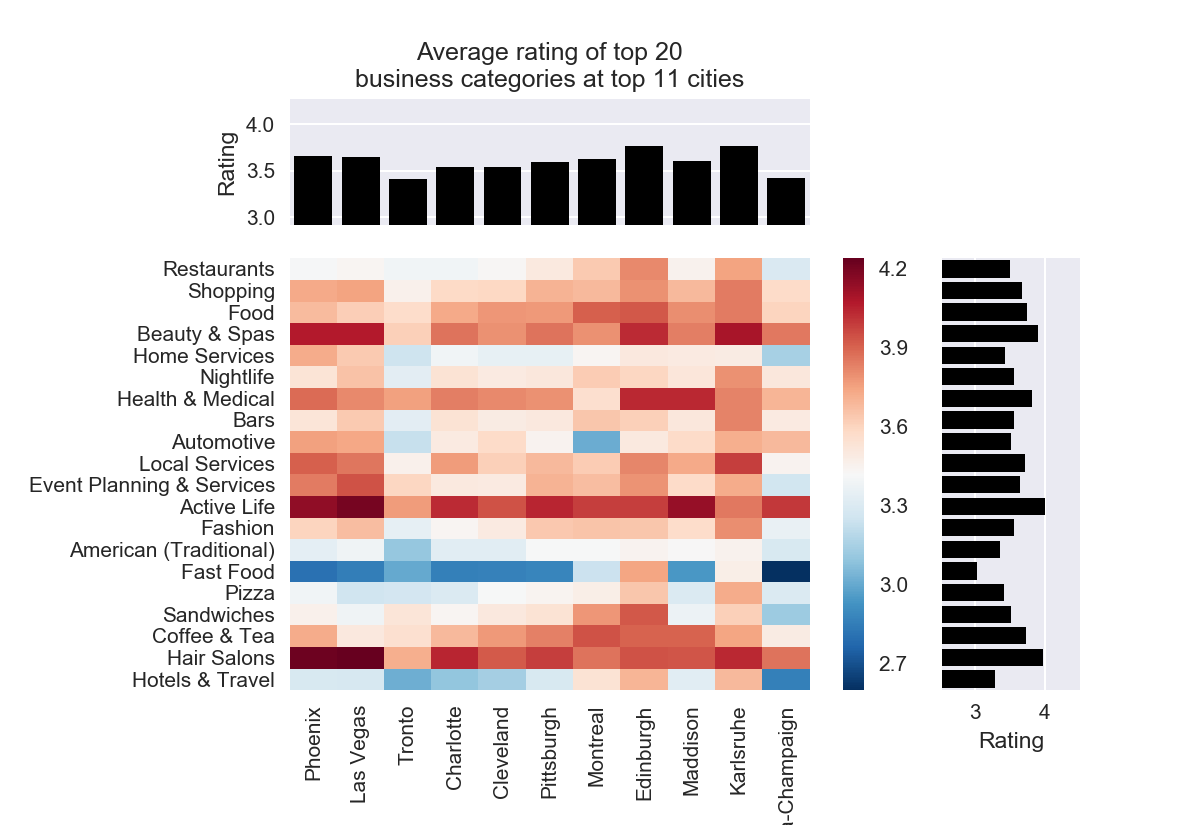

In [18]:
# city category rating
N1=11
N2=20
title='Average rating of top '+str(N2)+'\nbusiness categories at top '+str(N1)+' cities'
plot_rating_heat_map(N1,N2,avg_rating_city_category,title,0.5,0,'rating-top20category-city.png')

In [19]:
# calculate the review count for 11 city and top 20 category
N1=11
N2=20
TF_1=1
TF_2=1
review_count_city_category=calculate_review_count_two_column(N1,N2,city_freq,category_freq,business,'City','Category',TF_1,TF_2)
review_count_city_category.head(5)

,Phoenix,Las Vegas,Tronto,Charlotte,Cleveland,Pittsburgh,Montreal,Edinburgh,Maddison,Karlsruhe,Urbana-Champaign
Category,,,,,,,,,,,
Restaurants,733508,847482,360902,154754,135039,125044,86045,25069,61169,23477,19723
Shopping,104694,95035,30327,16668,11537,10099,4115,6460,6381,2782,2317
Food,207696,235612,110912,44142,39536,36761,27150,10925,19139,7002,5742
Beauty & Spas,87658,93292,21603,12115,7148,7178,1932,1139,3702,808,1334
Home Services,73326,47909,2626,5213,2255,2688,245,257,1805,270,814


<IPython.core.display.Javascript object>


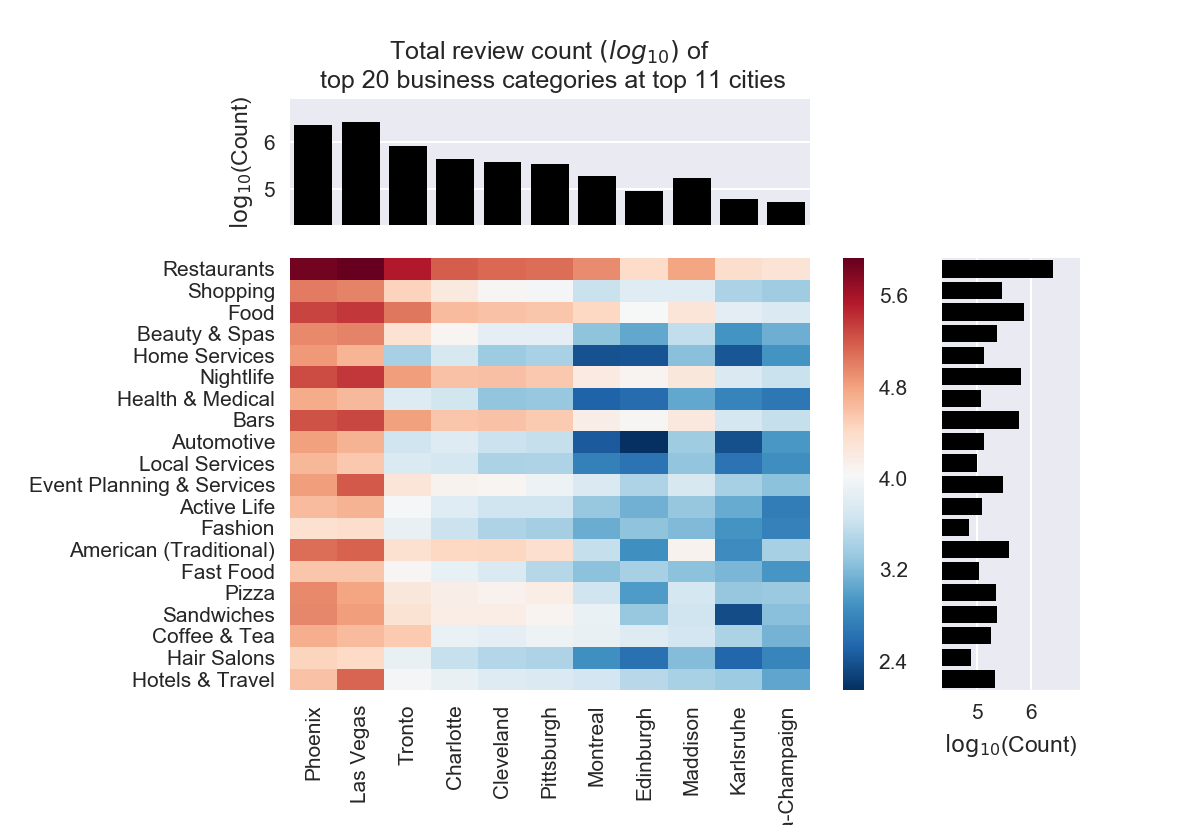

In [20]:
# city category review count
N1=11
N2=20
title='Total review count '+r'$(log_{10})$'+' of \n top '+str(N2)+' business categories at top '+str(N1)+' cities'
plot_review_count_heat_map(N1,N2,review_count_city_category,title,0.5,0,'review-count-top20category-city.png')

In [14]:
# calculate the average rating for top 20 category with top 20 attribute
N1=20 # of attribute
N2=20 # of category
TF_1=1 #
TF_2=1 #
avg_rating_category_attribute=calculate_avg_rating_two_column(N1,N2,attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
avg_rating_category_attribute.head(5)

,BusinessAcceptsCreditCards,BikeParking,RestaurantsTakeOut,GoodForKids,Alcohol,RestaurantsGoodForGroups,NoiseLevel,WheelchairAccessible,parking_lot,RestaurantsTableService,HasTV,OutdoorSeating,WiFi,amb_casual,RestaurantsReservations,parking_street,meal_lunch,Caters,ByAppointmentOnly,meal_dinner
Category,,,,,,,,,,,,,,,,,,,,
Restaurants,3.443753,3.562295,3.450521,3.454707,3.522596,3.468962,3.460004,3.552782,3.545428,3.518316,3.471777,3.534321,3.540657,3.559839,3.559889,3.685251,3.564665,3.609535,3.914286,3.589302
Shopping,3.692160,3.743829,3.557886,4.088295,3.682692,3.808411,3.736301,3.844314,3.685122,3.630769,3.792373,3.969388,4.062842,3.895522,3.683099,3.983411,3.685185,3.836207,4.042081,3.230769
Food,3.678422,3.733058,3.715049,3.708437,3.703002,3.691493,3.665985,3.798896,3.685740,3.679420,3.671145,3.702612,3.692521,3.736536,3.694958,3.924427,3.784343,3.807980,4.127273,3.727896
Beauty & Spas,3.942588,4.052399,3.250000,4.166938,3.454545,3.611111,3.433333,4.146783,4.049460,3.458333,3.736842,3.880952,3.830189,3.375000,3.944444,4.136010,4.250000,3.500000,4.264856,3.500000
Home Services,3.705079,3.660900,4.200000,4.130000,3.812500,4.153846,4.045455,3.607029,3.583333,4.500000,3.666667,3.916667,2.880282,4.000000,4.400000,4.058252,4.500000,4.333333,4.028282,4.250000


In [15]:
# calculate the average rating for top 20 category without top 20 attribute
N1=20 # of attribute
N2=20 # of category
TF_1=0 #
TF_2=1 #
avg_rating_category_no_attribute=calculate_avg_rating_two_column(N1,N2,attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
avg_rating_category_no_attribute.head(5)

,BusinessAcceptsCreditCards,BikeParking,RestaurantsTakeOut,GoodForKids,Alcohol,RestaurantsGoodForGroups,NoiseLevel,WheelchairAccessible,parking_lot,RestaurantsTableService,HasTV,OutdoorSeating,WiFi,amb_casual,RestaurantsReservations,parking_street,meal_lunch,Caters,ByAppointmentOnly,meal_dinner
Category,,,,,,,,,,,,,,,,,,,,
Restaurants,3.755114,3.384531,3.639538,3.471650,3.439282,3.391516,3.580251,3.560057,3.463996,3.397875,3.484920,3.436463,3.479248,3.431615,3.400839,3.446411,3.422983,3.378267,3.923077,3.420205
Shopping,3.837423,3.513893,3.295643,3.913889,3.822222,3.820000,4.033333,4.007567,3.664842,3.928571,3.912621,3.922652,3.706731,3.835766,3.926087,3.616699,3.575472,3.436782,3.805099,3.618497
Food,3.878030,3.575203,3.659461,3.696345,3.769565,3.745290,3.844482,3.898700,3.706365,3.745670,3.745644,3.666151,3.732253,3.702663,3.713875,3.635404,3.693488,3.646370,3.710599,3.723494
Beauty & Spas,4.152000,3.757143,3.038710,3.677551,3.272727,4.000000,3.142857,4.177184,3.876893,3.125000,3.464286,3.638889,3.125000,3.558824,3.300000,3.914644,3.145833,3.333333,3.755584,3.195652
Home Services,3.509980,3.505000,4.071429,3.631579,4.750000,4.750000,4.750000,4.062500,3.598196,3.833333,4.350000,4.642857,3.210526,4.571429,3.428571,3.533573,4.055556,3.666667,3.579649,4.111111


<IPython.core.display.Javascript object>


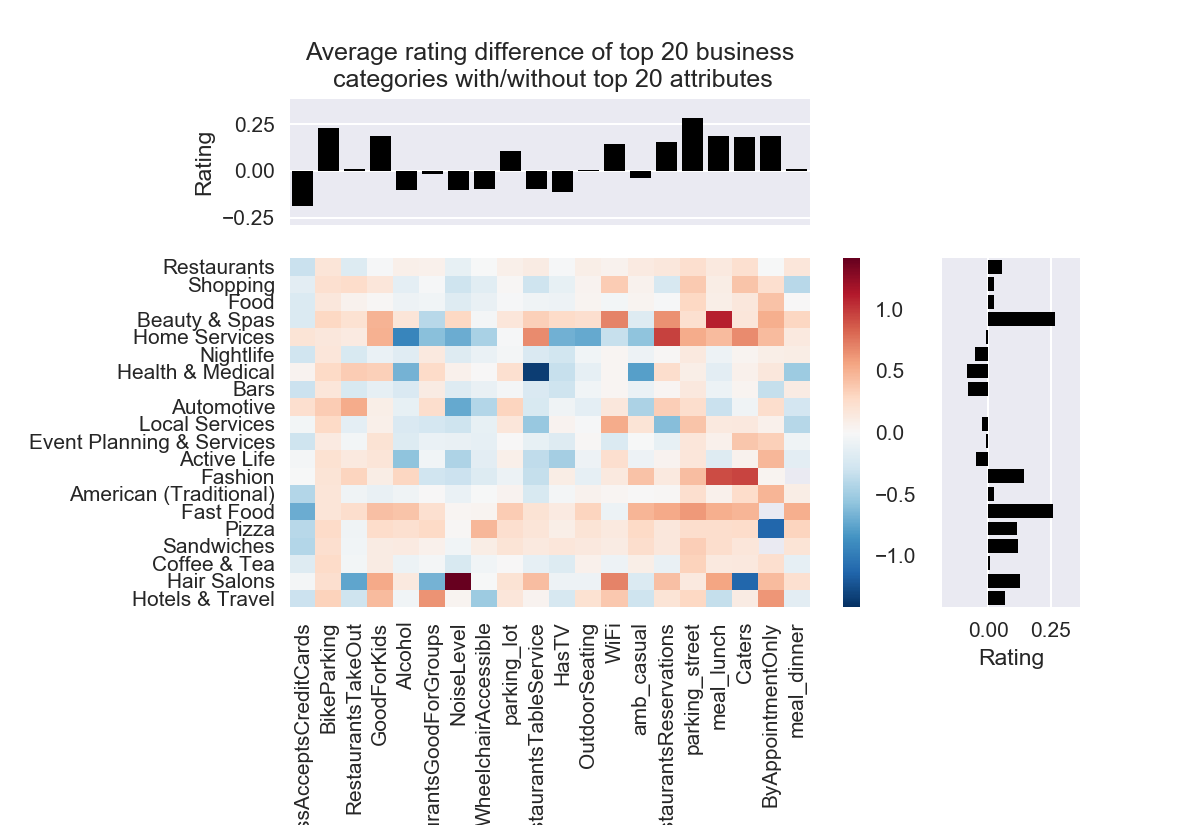

In [22]:
# 
N1=20
N2=20
title='Average rating difference of top '+str(N2)+' business\n categories with/without top '+str(N1)+' attributes'
plot_rating_heat_map(N1,N2,avg_rating_category_attribute-avg_rating_category_no_attribute,title,0.1
            ,1,'rating-difference-attribute-category.png')

<IPython.core.display.Javascript object>


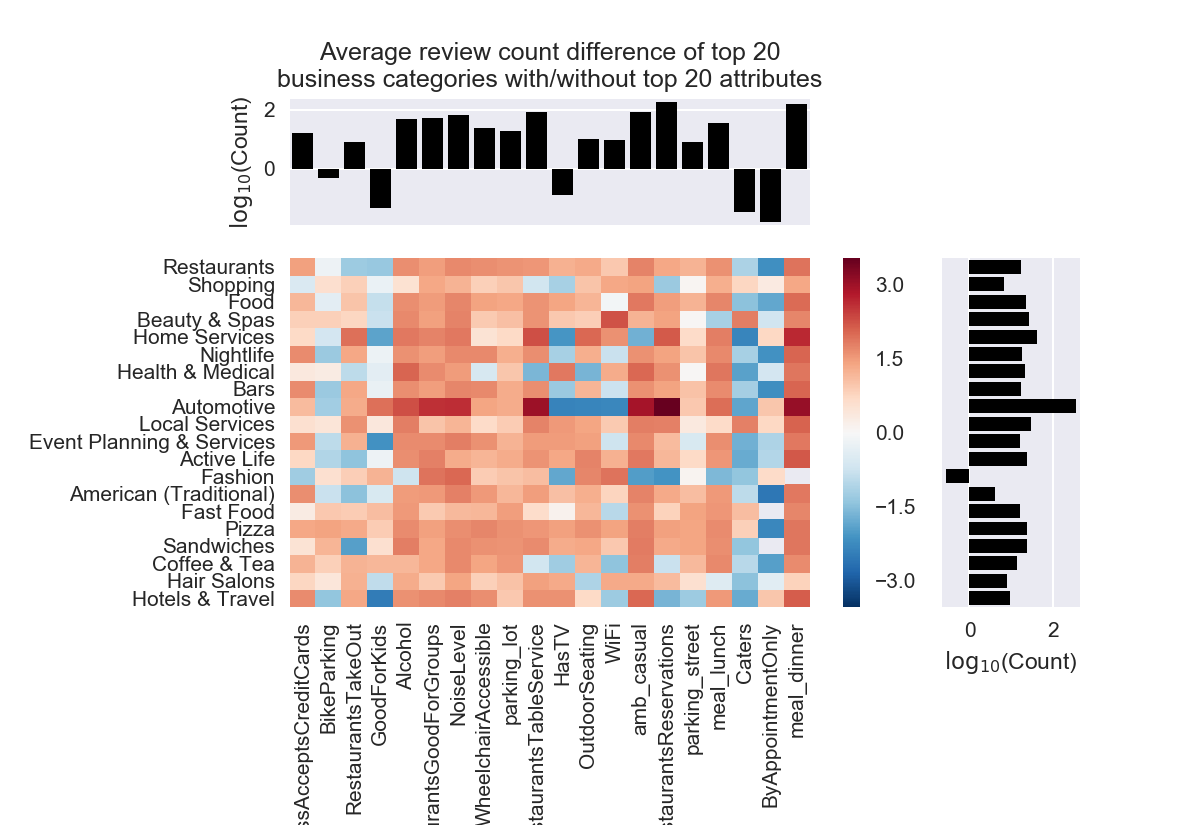

In [23]:
# calculate the average rating for top 20 category with top 20 attribute
N1=20 # of attribute
N2=20 # of category
TF_1=1 #
TF_2=1 #
avg_review_count_category_attribute=calculate_avg_review_count_two_column(N1,N2,attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
# calculate the average rating for top 20 category without top 20 attribute
N1=20 # of attribute
N2=20 # of category
TF_1=0 #
TF_2=1 #
avg_review_count_category_no_attribute=calculate_avg_review_count_two_column(N1,N2,attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
N1=20
N2=20
title='Average review count difference of top '+str(N2)+'\nbusiness categories with/without top '+str(N1)+' attributes'
plot_avg_review_count_heat_map(N1,N2,avg_review_count_category_attribute-avg_review_count_category_no_attribute,title,0.1
            ,1,'review-count-difference-attribute-category.png')

In [17]:
# get the frequency for general and specific attribute
general_attribute_freq=attribute_freq.set_index('Attribute')
general_attribute_freq=general_attribute_freq.transpose()
general_attribute_freq=general_attribute_freq[general_attribute].transpose()
general_attribute_freq=general_attribute_freq.reset_index()
specific_attribute_freq=attribute_freq.set_index('Attribute')
specific_attribute_freq=specific_attribute_freq.transpose()
specific_attribute_freq=specific_attribute_freq[specific_attribute].transpose()
specific_attribute_freq=specific_attribute_freq.reset_index()

In [24]:
# calculate the average rating for top 20 category with top 20 attribute
N1=10 # of attribute
N2=20 # of category
TF_1=1 #
TF_2=1 #
avg_rating_category_attribute=calculate_avg_rating_two_column(N1,N2,general_attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
# calculate the average rating for top 20 category without top 20 attribute
N1=10 # of attribute
N2=20 # of category
TF_1=0 #
TF_2=1 #
avg_rating_category_no_attribute=calculate_avg_rating_two_column(N1,N2,general_attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)

<IPython.core.display.Javascript object>


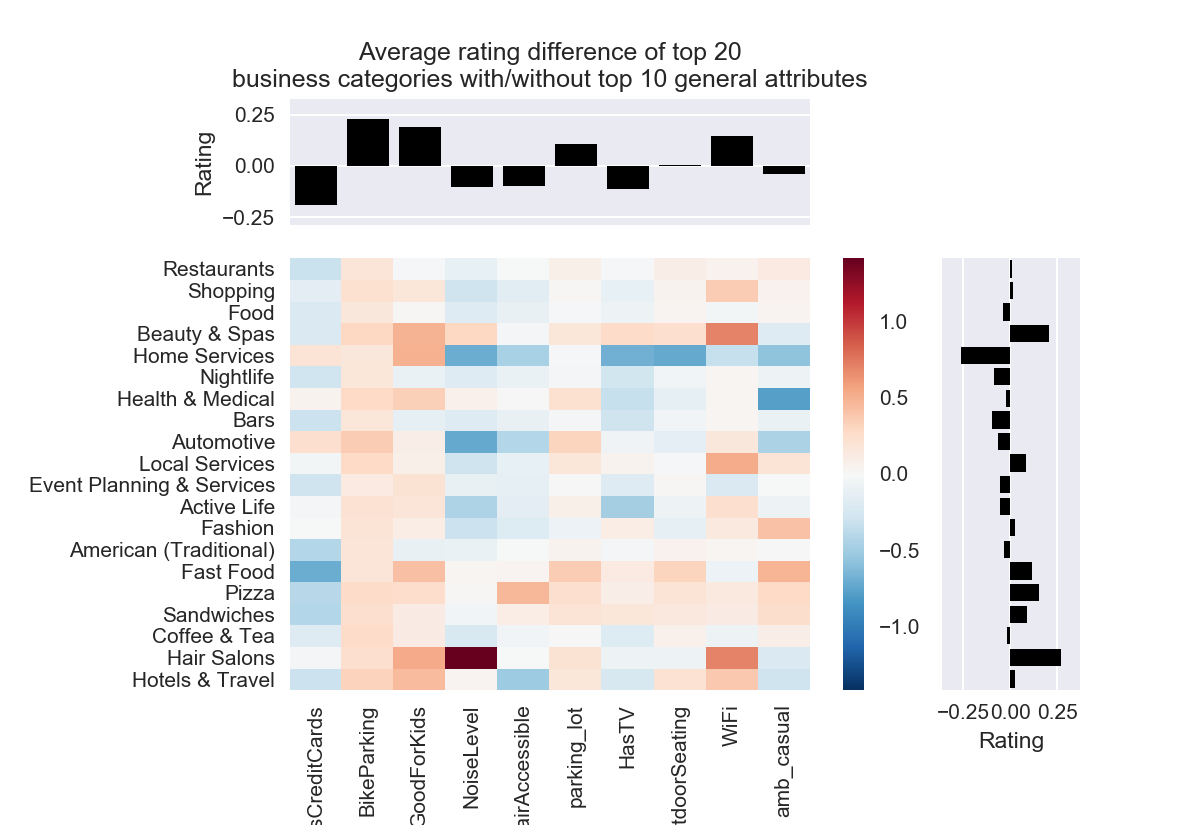

In [25]:
N1=10
N2=20
title='Average rating difference of top '+str(N2)+'\nbusiness categories with/without top '+str(N1)+' general attributes'
plot_rating_heat_map(N1,N2,avg_rating_category_attribute-avg_rating_category_no_attribute,title,0.1
            ,0,'rating-difference-general-attribute-category.png')

<IPython.core.display.Javascript object>


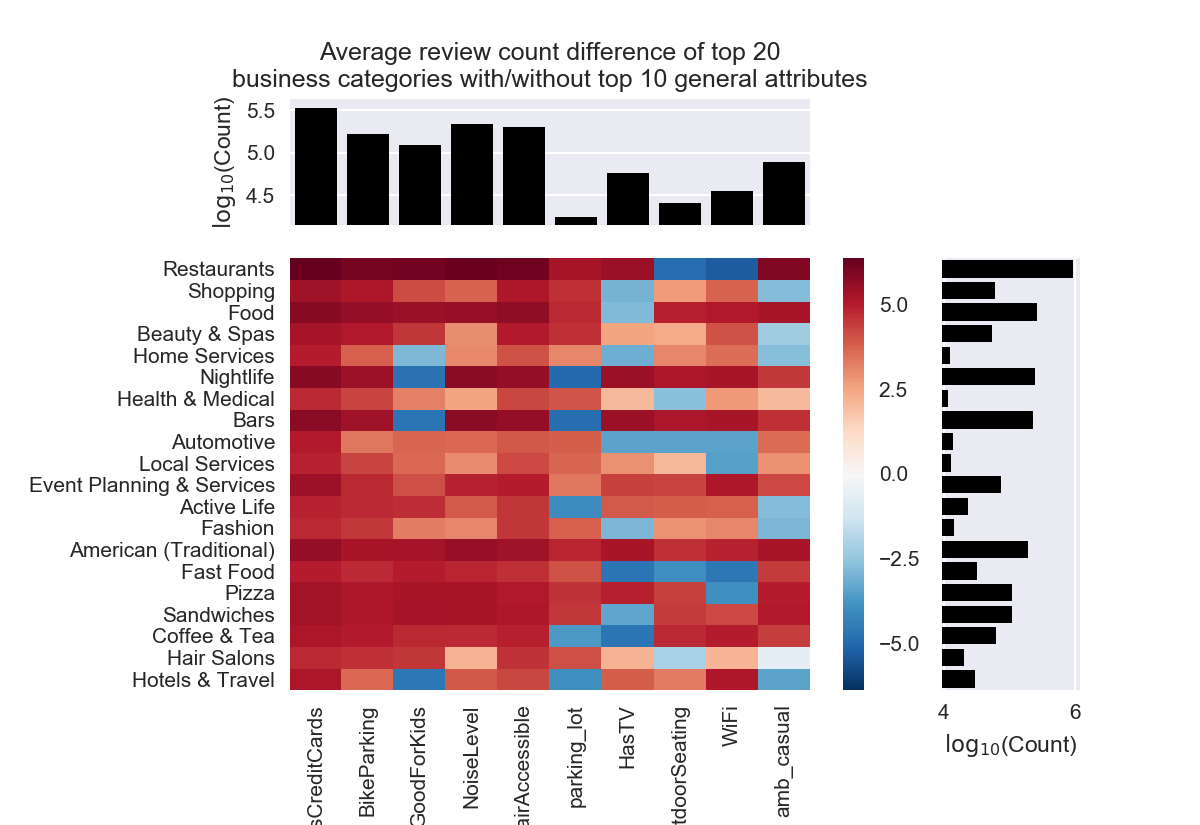

In [20]:
# calculate the average rating for top 20 category with top 20 attribute
N1=10 # of attribute
N2=20 # of category
TF_1=1 #
TF_2=1 #
avg_review_count_category_attribute=calculate_review_count_two_column(N1,N2,general_attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
# calculate the average rating for top 20 category without top 20 attribute
N1=10 # of attribute
N2=20 # of category
TF_1=0 #
TF_2=1 #
avg_review_count_category_no_attribute=calculate_review_count_two_column(N1,N2,general_attribute_freq,category_freq,business,'Attribute','Category',TF_1,TF_2)
N1=10
N2=20
title='Average review count difference of top '+str(N2)+'\nbusiness categories with/without top '+str(N1)+' general attributes'
plot_avg_review_count_heat_map(N1,N2,avg_review_count_category_attribute-avg_review_count_category_no_attribute,title,0.1
            ,1,'review-count-difference-general-attribute-category.png')

In [19]:
avg_review_count_category_no_attribute

,BusinessAcceptsCreditCards,BikeParking,GoodForKids,NoiseLevel,WheelchairAccessible,parking_lot,HasTV,OutdoorSeating,WiFi,amb_casual
Category,,,,,,,,,,
Restaurants,78441,566783,559755,252716,149861,1151191,1065307,1285308,1291838,814807
Shopping,6389,43547,9119,1375,11021,106298,4764,5408,2242,4468
Food,30996,137492,74428,52689,34099,330273,227192,224426,220033,133824
Beauty & Spas,10521,38997,17915,56,13819,89068,559,683,533,606
Home Services,13826,4651,1967,95,1141,7575,1375,92,344,957
Nightlife,11659,172757,298852,22239,47421,362926,162591,240554,160434,298842
Health & Medical,1695,5080,2281,119,2884,12046,280,569,132,275
Bars,10430,151404,276439,20323,43965,329103,140471,216279,154243,267882
Automotive,1250,4977,327,3,102,2802,3577,3584,3667,171


In [15]:
# food related
# 'Restaurants','Food','Bars','American (Traditional)','Fast Food',
# 'Pizza','Sandwiches','Coffee & Tea','Italian','Burgers','Mexican','American (New)',
# 'Chinese','Breakfast & Brunch','Specialty Food','Cafes','Bakeries'
restaurant_category=['Restaurants','Food','Bars','American (Traditional)','Fast Food',
'Pizza','Sandwiches','Coffee & Tea','Italian','Burgers','Mexican','American (New)',
'Chinese','Breakfast & Brunch','Specialty Food','Cafes','Bakeries']
restaurant_category_freq=category_freq.set_index('Category')
restaurant_category_freq=restaurant_category_freq.transpose()
restaurant_category_freq=restaurant_category_freq[restaurant_category].transpose()
restaurant_category_freq=restaurant_category_freq.reset_index()

In [32]:
# calculate the average rating for top 20 category with top 20 attribute
N1=10 # of attribute
N2=16 # of category
TF_1=1 #
TF_2=1 #
avg_rating_category_attribute=calculate_avg_rating_two_column(N1,N2,specific_attribute_freq,restaurant_category_freq,business,'Attribute','Category',TF_1,TF_2)
avg_rating_category_attribute.head(5)

,RestaurantsTakeOut,Alcohol,RestaurantsGoodForGroups,RestaurantsTableService,RestaurantsReservations,meal_lunch,Caters,meal_dinner,RestaurantsDelivery,HappyHour
Category,,,,,,,,,,
Restaurants,3.450521,3.522596,3.468962,3.518316,3.559889,3.564665,3.609535,3.589302,3.444132,3.456839
Food,3.715049,3.703002,3.691493,3.679420,3.694958,3.784343,3.807980,3.727896,3.763780,3.674627
Bars,3.474493,3.518722,3.525170,3.480765,3.554804,3.445262,3.532812,3.558760,3.503571,3.503589
American (Traditional),3.330103,3.322766,3.328961,3.300564,3.346339,3.379205,3.527310,3.405336,3.478166,3.307453
Fast Food,2.938479,3.345960,2.965946,3.169355,3.444737,3.314895,3.258649,3.416211,3.375803,3.136364


In [33]:
# calculate the average rating for top 20 category with top 20 attribute
N1=10 # of attribute
N2=16 # of category
TF_1=0 #
TF_2=1 #
avg_rating_category_no_attribute=calculate_avg_rating_two_column(N1,N2,specific_attribute_freq,restaurant_category_freq,business,'Attribute','Category',TF_1,TF_2)
avg_rating_category_no_attribute.head(5)

,RestaurantsTakeOut,Alcohol,RestaurantsGoodForGroups,RestaurantsTableService,RestaurantsReservations,meal_lunch,Caters,meal_dinner,RestaurantsDelivery,HappyHour
Category,,,,,,,,,,
Restaurants,3.639538,3.439282,3.391516,3.397875,3.400839,3.422983,3.378267,3.420205,3.470511,3.633299
Food,3.659461,3.769565,3.745290,3.745670,3.713875,3.693488,3.646370,3.723494,3.746055,3.819608
Bars,3.702690,3.736559,3.409524,3.691882,3.532661,3.523286,3.498925,3.447004,3.502258,3.609616
American (Traditional),3.389610,3.387060,3.326715,3.530597,3.328543,3.305948,3.267575,3.296035,3.316543,3.358156
Fast Food,2.691176,2.940415,2.735457,2.963276,2.905524,2.799578,2.779435,2.901305,2.876264,3.375000


<IPython.core.display.Javascript object>


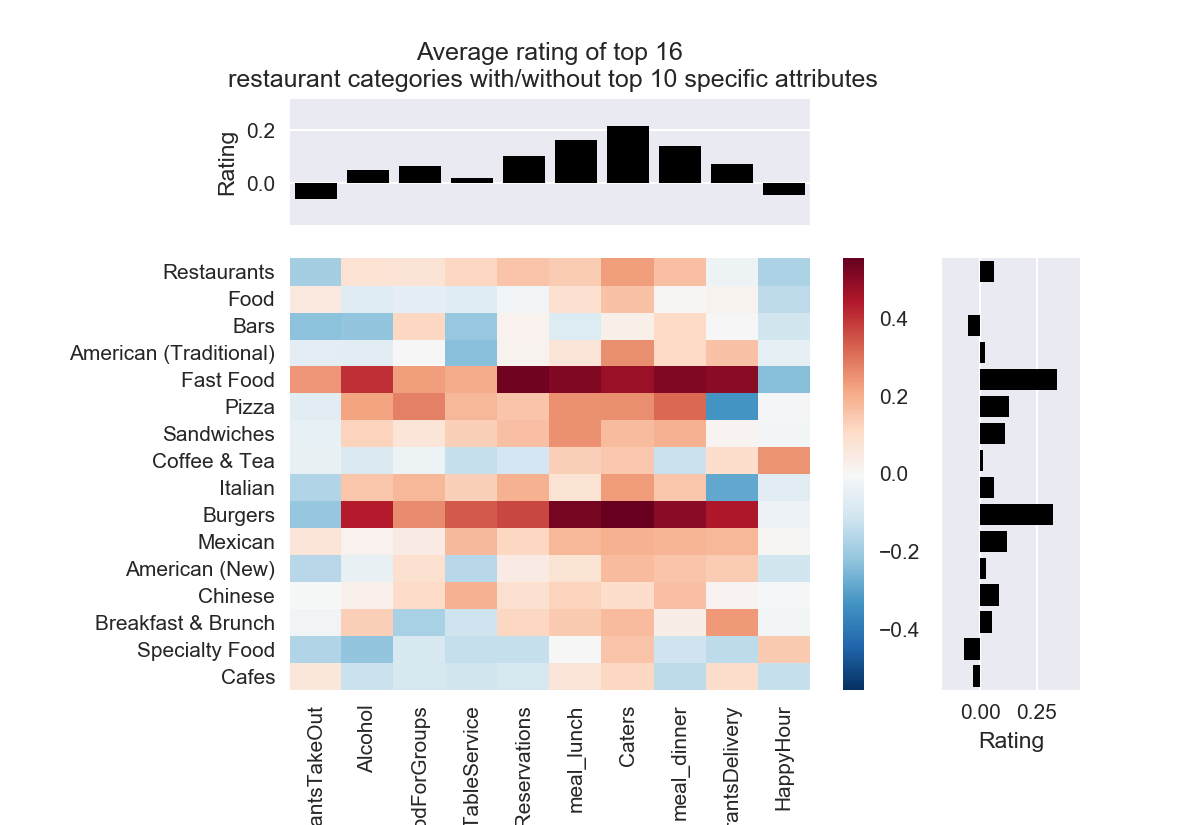

In [35]:
N1=10
N2=16
title='Average rating of top '+str(N2)+'\n restaurant categories with/without top '+str(N1)+' specific attributes'
plot_rating_heat_map(N1,N2,avg_rating_category_attribute-avg_rating_category_no_attribute,title,0.1
            ,1,'rating-different-specific-attribute-restaurants.png')

<IPython.core.display.Javascript object>


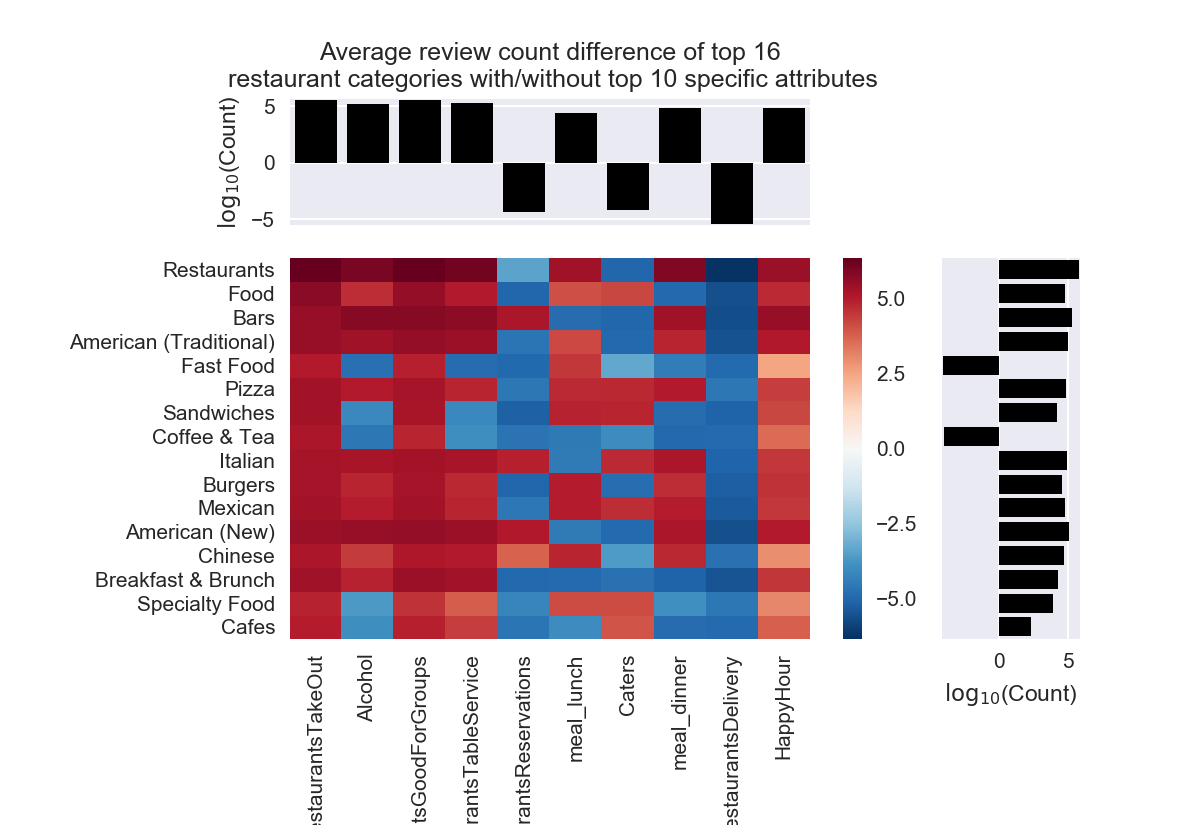

In [18]:
# calculate the average rating for top 20 category with top 20 attribute
N1=10 # of attribute
N2=16 # of category
TF_1=1 #
TF_2=1 #
avg_review_count_category_attribute=calculate_review_count_two_column(N1,N2,specific_attribute_freq,restaurant_category_freq,business,'Attribute','Category',TF_1,TF_2)
# calculate the average rating for top 20 category without top 20 attribute
N1=10 # of attribute
N2=16 # of category
TF_1=0 #
TF_2=1 #
avg_review_count_category_no_attribute=calculate_review_count_two_column(N1,N2,specific_attribute_freq,restaurant_category_freq,business,'Attribute','Category',TF_1,TF_2)
N1=10
N2=16
title='Average review count difference of top '+str(N2)+'\n restaurant categories with/without top '+str(N1)+' specific attributes'
plot_avg_review_count_heat_map(N1,N2,avg_review_count_category_attribute-avg_review_count_category_no_attribute,title,0.1
            ,1,'review-count-difference-specific-attribute-category.png')

In [125]:
# test train x y tags
X_tag=list()
X_tag.extend(business_category_dummy.columns.tolist())
X_tag.extend(business_attribute.columns.tolist())
X_tag.extend(business_city_dummy.columns.tolist())
X_tag.remove('SC')
X_tag.remove('NY')
X_tag.remove('VT')
X_tag.extend(business_operation_hour.columns.tolist())
y_tag='review_count'
XX=business;
X=XX[X_tag].astype(float)
y=XX[y_tag].astype(float)
# for rating
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [128]:
clf1=KNeighborsRegressor()
clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.27438038040279711

In [124]:
# decision tree
clf1=DecisionTreeClassifier(max_depth=10,random_state=42);
clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.68516524476103702

In [86]:
clf1=LinearRegression();
clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.2661505093102291

In [78]:
len(y_test[y_test=='>3'])/len(y_test)

0.6422595875093183

In [47]:
# random forest
clf2=RandomForestClassifier(max_depth=10,random_state=42);
clf2.fit(X_train,y_train)
clf2.score(X_test,y_test)

0.74502646976873776

In [25]:
# logistic regress
clf3=LogisticRegression(random_state=42)
clf3.fit(X_train,y_train)
clf3.score(X_test,y_test)

0.71889105600445802

In [37]:
A=list(clf2.feature_importances_)

In [40]:
# city 11 columns attribute 52 category 191 hour 14

total_importance_city=sum(A[0:11])
total_importance_attribute=sum(A[11:63])
total_importance_category=sum(A[63:254])
total_importance_hour=sum(A[254:268])
print(total_importance_city,total_importance_attribute,total_importance_category,total_importance_hour)

In [121]:
category_check='Restaurants'
operation_day_check='Wednesday'
operation_op_hrs_max=24
operation_op_hrs_min=18
city_check='Las Vegas'

(business[(business[category_check]==1) & (business[operation_day_check+'_op_hrs']<operation_op_hrs_max) &
          (business[operation_day_check+'_op_hrs']>operation_op_hrs_min) & 
          (business[city_check]==1)]['stars']).describe()

count    67.000000
mean      3.171642
std       0.751525
min       1.000000
25%       2.500000
50%       3.000000
75%       3.500000
max       5.000000
Name: stars, dtype: float64